Original Class Distribution:
label
onboarding                700
general_Enquiry           700
internal_coordination     699
system_notification       676
client_feedback           669
job_application           618
candidate_availability    600
candidate_response        600
offer_sent                600
interview_confirmation    600
offer_response            600
interview_feedback        600
candidate_application     596
client_submission         557
spam                      523
new_requisition           515
interview_scheduling      510
candidate_selection       454
Name: count, dtype: int64

Balanced Class Distribution:
label
candidate_application     450
candidate_availability    450
spam                      450
onboarding                450
offer_sent                450
offer_response            450
new_requisition           450
job_application           450
interview_scheduling      450
interview_feedback        450
interview_confirmation    450
internal_coordination     450
gen

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification mod

Epoch 1/5
355/355 [==============================] - ETA: 0s - loss: 0.9203 - accuracy: 0.8951
Epoch 1: val_loss improved from inf to 0.10191, saving model to checkpoints\ckpt
355/355 [==============================] - 2856s 8s/step - loss: 0.9203 - accuracy: 0.8951 - val_loss: 0.1019 - val_accuracy: 0.9963 - lr: 2.0000e-05
Epoch 2/5
355/355 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9995
Epoch 2: val_loss improved from 0.10191 to 0.03154, saving model to checkpoints\ckpt
355/355 [==============================] - 2424s 7s/step - loss: 0.0591 - accuracy: 0.9995 - val_loss: 0.0315 - val_accuracy: 0.9969 - lr: 2.0000e-05
Epoch 3/5
355/355 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.03154 to 0.01361, saving model to checkpoints\ckpt
355/355 [==============================] - 2432s 7s/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 0.9982 - lr: 2.0000e-05
Epoch 4/5
355/

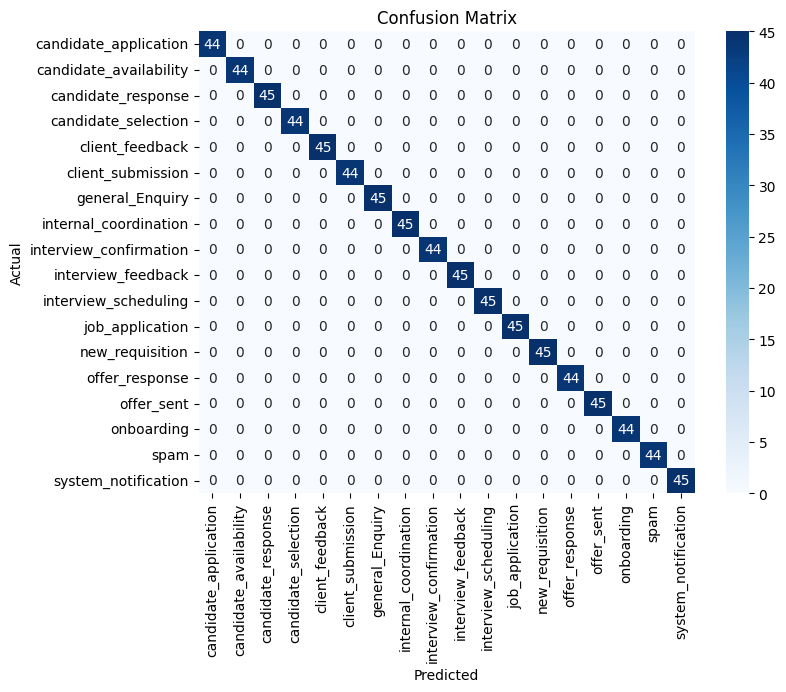

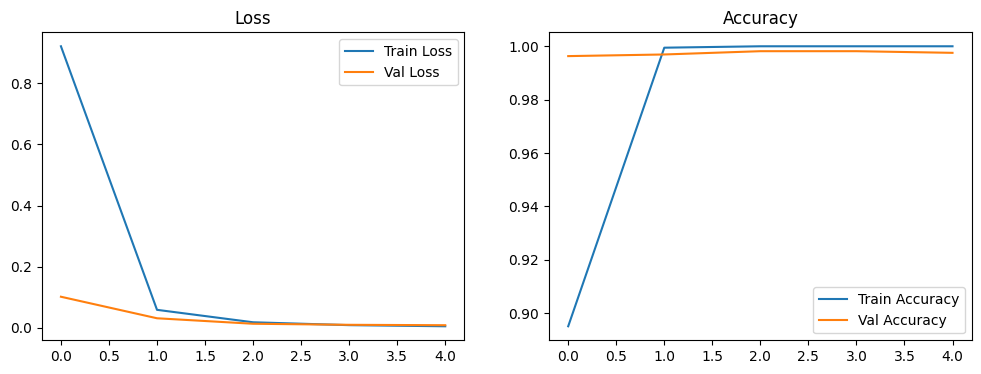

{'predicted_class': 'job_application', 'confidence': 0.9844244122505188}


('ats_tokenizer\\tokenizer_config.json',
 'ats_tokenizer\\special_tokens_map.json',
 'ats_tokenizer\\vocab.txt',
 'ats_tokenizer\\added_tokens.json',
 'ats_tokenizer\\tokenizer.json')

In [1]:
# ===================== COMPLETE DISTILBERT-BASED ATS EMAIL CLASSIFIER =====================
# Copy–Paste Ready | Small Model | Resume Training | No Optimizer Bloat
# ========================================================================================

# ---------- STEP 0: IMPORT LIBRARIES ----------
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

# ---------- STEP 1: LOAD & CLEAN DATA ----------
df = pd.read_csv("E:\\Talentprism\\data\\final_training_data_with_missing_classes.csv")
df.columns = ["label", "text"]

df = df.dropna(subset=["label", "text"])
df = df.drop_duplicates(subset=["text"])
df = df.sample(frac=1, random_state=42)

print("Original Class Distribution:")
print(df["label"].value_counts())

# ---------- STEP 2: BALANCE DATASET ----------
df_balanced = df.groupby("label").apply(
    lambda x: x.sample(min(len(x), 450), random_state=42)
).reset_index(drop=True)

print("\nBalanced Class Distribution:")
print(df_balanced["label"].value_counts())

# ---------- STEP 3: LABEL ENCODING ----------
label_encoder = LabelEncoder()
df_balanced["label_encoded"] = label_encoder.fit_transform(df_balanced["label"])

num_classes = df_balanced["label_encoded"].nunique()
print("\nClasses:", label_encoder.classes_)

# ---------- STEP 4: TRAIN / VAL / TEST SPLIT ----------
X_train, X_temp, y_train, y_temp = train_test_split(
    df_balanced["text"],
    df_balanced["label_encoded"],
    test_size=0.3,
    stratify=df_balanced["label_encoded"],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.33,
    stratify=y_temp,
    random_state=42
)

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ---------- STEP 5: LOAD DISTILBERT TOKENIZER ----------
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

# ---------- STEP 6: TOKENIZATION ----------
def encode_texts(texts, tokenizer, max_len=256):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

train_enc = encode_texts(X_train, tokenizer)
val_enc   = encode_texts(X_val, tokenizer)
test_enc  = encode_texts(X_test, tokenizer)

# ---------- STEP 7: CLASS WEIGHTS ----------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("\nClass Weights:", class_weight_dict)

# ---------- STEP 8: LOAD DISTILBERT MODEL ----------
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_classes,
    from_pt=True
)

# ---------- STEP 9: COMPILE MODEL ----------
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# ---------- STEP 10: CALLBACKS ----------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=1,
    min_lr=1e-7,
    verbose=1
)

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "ckpt"),
    save_weights_only=True,     # IMPORTANT
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# ---------- STEP 11: RESUME FROM CHECKPOINT IF EXISTS ----------
latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
if latest_ckpt:
    print(f"Resuming from checkpoint: {latest_ckpt}")
    model.load_weights(latest_ckpt)

# ---------- STEP 12: TRAIN MODEL ----------
history = model.fit(
    dict(train_enc),
    y_train,
    validation_data=(dict(val_enc), y_val),
    epochs=5,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb, early_stop, reduce_lr],
    verbose=1
)

# ---------- STEP 13: EVALUATE ----------
test_preds = model.predict(dict(test_enc))
y_pred = np.argmax(test_preds.logits, axis=1)

print("\n--- Classification Report ---")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

# ---------- STEP 14: CONFUSION MATRIX ----------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- STEP 15: TRAINING CURVES ----------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

# ---------- STEP 16: CONFIDENCE-AWARE PREDICTION ----------
def predict_email(text, threshold=0.7):
    enc = tokenizer(
        text,
        return_tensors="tf",
        truncation=True,
        padding=True,
        max_length=256
    )

    logits = model(enc).logits
    probs = tf.nn.softmax(logits, axis=1)
    idx = tf.argmax(probs, axis=1).numpy()[0]
    confidence = float(probs[0][idx])

    result = {
        "predicted_class": label_encoder.classes_[idx],
        "confidence": confidence
    }

    if confidence < threshold:
        result["warning"] = "Low confidence prediction"

    return result

print(predict_email("Dear HR, I am applying for the Data Scientist position."))

# ---------- STEP 17: SAVE FINAL ARTIFACTS ----------
model.save_weights("ats_distilbert_weights")      # ~250 MB
tokenizer.save_pretrained("ats_tokenizer")        # <5 MB

# ===================== END OF COMPLETE CODE =====================


In [5]:
sample_email = """Subject: 🚨 Urgent! Your Account Has Been Compromised – Verify Now

Dear Customer,

We detected suspicious activity on your account. For your safety, we have temporarily limited access to your account.

To restore full access, please verify your details immediately by clicking the secure link below:

👉 Verify Your Account Now

Failure to verify within 24 hours may result in permanent suspension of your account.

Thank you for your prompt attention.

Sincerely,
Security Team
Customer Support Department"""
print(predict_email(sample_email))


{'predicted_class': 'spam', 'confidence': 0.7156088948249817}


In [18]:
print(predict_email("Please let me know money money moeny the next steps."))


{'predicted_class': 'internal_coordination', 'confidence': 0.35587278008461, 'warning': 'Low confidence prediction'}


In [8]:
print(predict_email("""Hi,


Greetings!

    
You are just a step away from accessing your Flipkart Seller account


We are sharing a verification code to access your account. The code is valid for 10 minutes and usable only once."""))


{'predicted_class': 'spam', 'confidence': 0.9257605671882629}


In [9]:
# ---------------- SAMPLE EMAILS FOR EACH CATEGORY ----------------

sample_emails = {

    "job_application": [
        """Dear Hiring Manager,
        I am writing to apply for the Data Scientist position at your organization.
        I have attached my resume for your review and believe my skills in Python,
        machine learning, and data analysis align well with the role requirements.
        I look forward to hearing from you regarding the next steps.""",

        """Hello Team,
        I would like to formally apply for the Software Engineer role advertised on your careers page.
        With hands-on experience in backend development and problem-solving,
        I am confident I can contribute effectively to your team.
        Please find my resume attached for further details.""",

        """Respected Sir/Madam,
        I am interested in the Machine Learning Engineer position currently open at your company.
        My academic background and project experience closely match the job description.
        Kindly consider my application for further evaluation."""
    ],

    "candidate_application": [
        """Thank you for applying for the position with our organization.
        We have successfully received your application and resume.
        Our hiring team is currently reviewing all applications,
        and we will contact you regarding the next steps within 3–5 business days.""",

        """This email is to confirm that your job application has been received.
        Our recruitment team will carefully review your profile based on the role requirements.
        If shortlisted, you will be contacted for the next stage of the hiring process.""",

        """We appreciate your interest in joining our company.
        Your application has been submitted successfully and is now under review.
        Due to the high volume of applications, this process may take some time.
        Thank you for your patience."""
    ],

    "interview_scheduling": [
        """Dear Candidate,
        We are pleased to inform you that you have been shortlisted for the next round.
        Your technical interview has been scheduled for Monday at 11:00 AM via video call.
        Please confirm your availability or let us know if rescheduling is required.""",

        """Congratulations on moving forward in the selection process.
        We would like to schedule your interview with our technical panel this week.
        Kindly share your availability for the next three working days so we can proceed.""",

        """This is regarding your application for the mentioned position.
        We would like to arrange an interview to discuss your profile in detail.
        Please reply to this email with your preferred time slot."""
    ],

    "candidate_selection": [
        """Congratulations!
        We are delighted to inform you that you have been selected for the Data Analyst role.
        You have successfully cleared all interview rounds.
        Our HR team will reach out to you shortly with the offer letter and joining details.""",

        """We are pleased to confirm your selection for the advertised position.
        Your performance throughout the interview process was impressive.
        Further documentation and onboarding information will be shared soon.""",

        """Thank you for participating in our interview process.
        We are happy to inform you that you have been shortlisted and selected.
        Please keep an eye on your inbox for the next steps from our HR department."""
    ],

    "spam": [
        """URGENT!!!
        Congratulations! You have been selected as the lucky winner of a brand-new iPhone.
        Click the link below to claim your prize before the offer expires.
        Act fast to avoid missing out on this limited-time opportunity!""",

        """You are a lucky user!
        Earn up to ₹50,000 per month working from home with zero investment.
        No experience required. Click now to register and start earning today!""",

        """FINAL NOTICE!!!
        Your account has been selected for a cash reward.
        Verify your details immediately to receive your prize.
        Failure to respond may result in forfeiture of the reward."""
    ]
}


# ---------------- RUN PREDICTIONS ----------------

for category, emails in sample_emails.items():
    print(f"\n================ CATEGORY: {category.upper()} ================")
    
    for email in emails:
        result = predict_email(email)
        print(f"\nEmail: {email}")
        print(f"Prediction: {result}")



================ CATEGORY: JOB_APPLICATION ================

Email: Dear Hiring Manager,
        I am writing to apply for the Data Scientist position at your organization.
        I have attached my resume for your review and believe my skills in Python,
        machine learning, and data analysis align well with the role requirements.
        I look forward to hearing from you regarding the next steps.
Prediction: {'predicted_class': 'job_application', 'confidence': 0.9962831139564514}

Email: Hello Team,
        I would like to formally apply for the Software Engineer role advertised on your careers page.
        With hands-on experience in backend development and problem-solving,
        I am confident I can contribute effectively to your team.
        Please find my resume attached for further details.
Prediction: {'predicted_class': 'job_application', 'confidence': 0.972705602645874}

Email: Respected Sir/Madam,
        I am interested in the Machine Learning Engineer position c